# Model parameter estimation for an irregularly-sampled, continuous-discrete (non-linear) Gaussian dynamical system

We show how to use cd-dynamax to estimate the parameters of a continuous-discrete (non-linear) Gaussian dynamical system



## Preliminaries

### Code Setup

In [1]:
# Main imports
import sys
from itertools import count

# Import jax and utils
from jax import numpy as jnp
from jax import vmap
import jax.random as jr
from jax import jit, vmap

# Additional, custom codebase
sys.path.append("../..")
sys.path.append("../../..")

# Our own custom src codebase
# continuous-discrete nonlinear Gaussian SSM codebase
from utils.plotting_utils import *
# CD-Nonlinear Gaussian models
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm.models import *

# Plotting
import matplotlib
%matplotlib inline
# Our own custom plotting codebase
from utils.plotting_utils import *
from lorenz_plotting import *
# Feel free to change the default figure size
#matplotlib.rcParams['figure.figsize'] = [16, 9]


/opt/homebrew/anaconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


# Generate synthetic data

We generate data from a Lorenz 63 system, from dynamics with the following stochastic differential equations:
\begin{align*}
\frac{d x}{d t} &= a(y-x) + \sigma w_x(t) \\
\frac{d y}{d t} &= x(b-z) - y + \sigma w_y(t) \\
\frac{d z}{d t} &= xy - cz + \sigma w_z(t),
\end{align*}

With parameters $a=10, b=28, c=8/3$, the system gives rise to chaotic behavior, and we choose $\sigma=0.1$ for light diffusion.

To generate data, we numerically approximate random path solutions to this SDE using Heun's method (i.e. improved Euler), as implemented in [Diffrax](https://docs.kidger.site/diffrax/api/solvers/sde_solvers/).


We assume the observation model is
\begin{align*}
y(t) &= H x(t) + r(t) \\
r(t) &\sim N(0,R),
\end{align*}
where we choose $R=I$. 

Namely, with H=I, we have full observability, with noisy observations, sampled at irregular time intervals.

### True, data-generating model definition

In [2]:
## Main settings
state_dim = 3
emission_dim = 3

# Define a custom drift model, inherited from LearnableFunction
class lorenz63_drift(LearnableFunction):
    params: Union[Float[Array, "state_dim"], ParameterProperties]

    def f(self, x, u=None, t=None):
        foo = jnp.array(
            [
                self.params[0] * (x[1] - x[0]),
                self.params[1] * x[0] - x[1] - x[0] * x[2],
                -self.params[2] * x[2] + x[0] * x[1],
            ]
        )
        return foo

# Define the true parameters of the drift function
true_l63_drift_params = jnp.array([10.0, 28.0, 8 / 3])
# And the corresponding Lorenz 63 system
true_drift = {
    "params": lorenz63_drift(
        params=true_l63_drift_params
    ),
    "props": lorenz63_drift(
        params=ParameterProperties()
    ),
}

# Define the true parameters of the diffusion function
true_diffusion_cov = {
    "params": LearnableMatrix(
        params=jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the true parameters of the diffusion function
true_diffusion_coefficient_param = 0.1
true_diffusion_coefficient = {
    "params": LearnableMatrix(
        params=true_diffusion_coefficient_param * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties()
    ),
}

# Define the true parameters of the emission function
# Full observability
H=jnp.eye(emission_dim,state_dim)
true_emission = {
    "params": LearnableLinear(
        weights=H,
        bias=jnp.zeros(emission_dim)
    ),
    "props": LearnableLinear(
        weights=ParameterProperties(),
        bias=ParameterProperties()
    ),
}

# Define the true parameters of the emission covariance
R=jnp.eye(emission_dim)
true_emission_cov = {
    "params": LearnableMatrix(
        params=R
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the true initial mean and covariance
true_initial_mean = {
    "params": LearnableVector(
        params=jnp.zeros(state_dim)
    ),
    "props": LearnableVector(
        params=ParameterProperties()
    ),
}

true_initial_cov_param = 10.0
true_initial_cov = {
    "params": LearnableMatrix(
        params=true_initial_cov_param*jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Concatenate all parameters in dictionary, for later easy use
all_true_params = {
    'initial_mean': true_initial_mean,
    'initial_cov': true_initial_cov,
    'dynamics_drift': true_drift,
    'dynamics_diffusion_coefficient': true_diffusion_coefficient,
    'dynamics_diffusion_cov': true_diffusion_cov,
    'dynamics_approx_order': 2., # Check on this later
    'emission_function': true_emission,
    'emission_cov': true_emission_cov,
}

### Simulation set-up

In [3]:
# Simulation parameters
T = 300
num_timesteps = 30000

# We collect measurements at irregular times sampled uniformly from a time domain $[0,40]$.
t_emissions = jnp.array(
        sorted(
            jr.uniform(
                jr.PRNGKey(0),
                (num_timesteps, 1),
                minval=0,
                maxval=T
            )
        )
    )
# drop duplicates
t_emissions = jnp.unique(t_emissions)[:, None]
num_timesteps = len(t_emissions)

# Set up seed for simulation
keys = map(jr.PRNGKey, count())

### Model creation: object instantiation

In [4]:
# Create CD-NLGSSM model
true_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
true_params, _ = true_model.initialize(
    next(keys),
    **all_true_params
)

### Simulate data: sample from model

In [5]:
# sample true states and emissions from defined true model.
# Using transition_type="path" to solve the dynamics SDE.
true_states, true_emissions = true_model.sample(
    true_params,
    next(keys),
    num_timesteps,
    t_emissions,
    transition_type="path" # uses the Euler-Maruyama method
)

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.


### Plot generated data

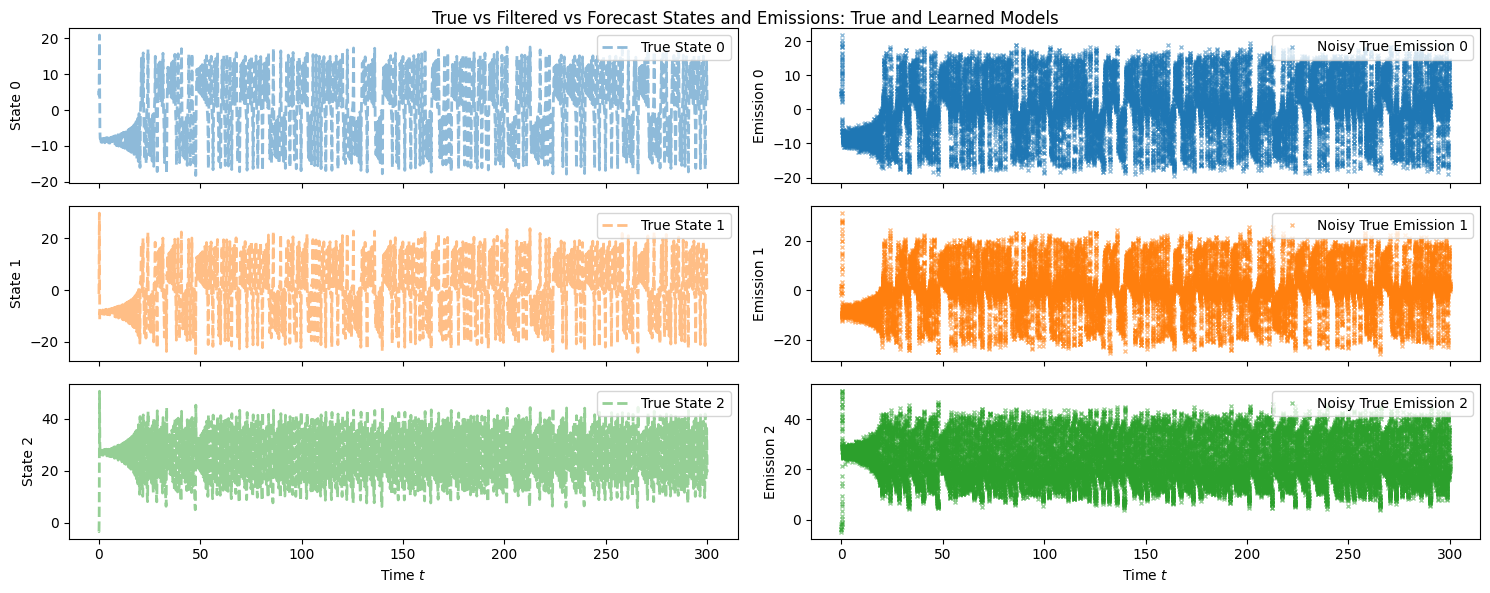

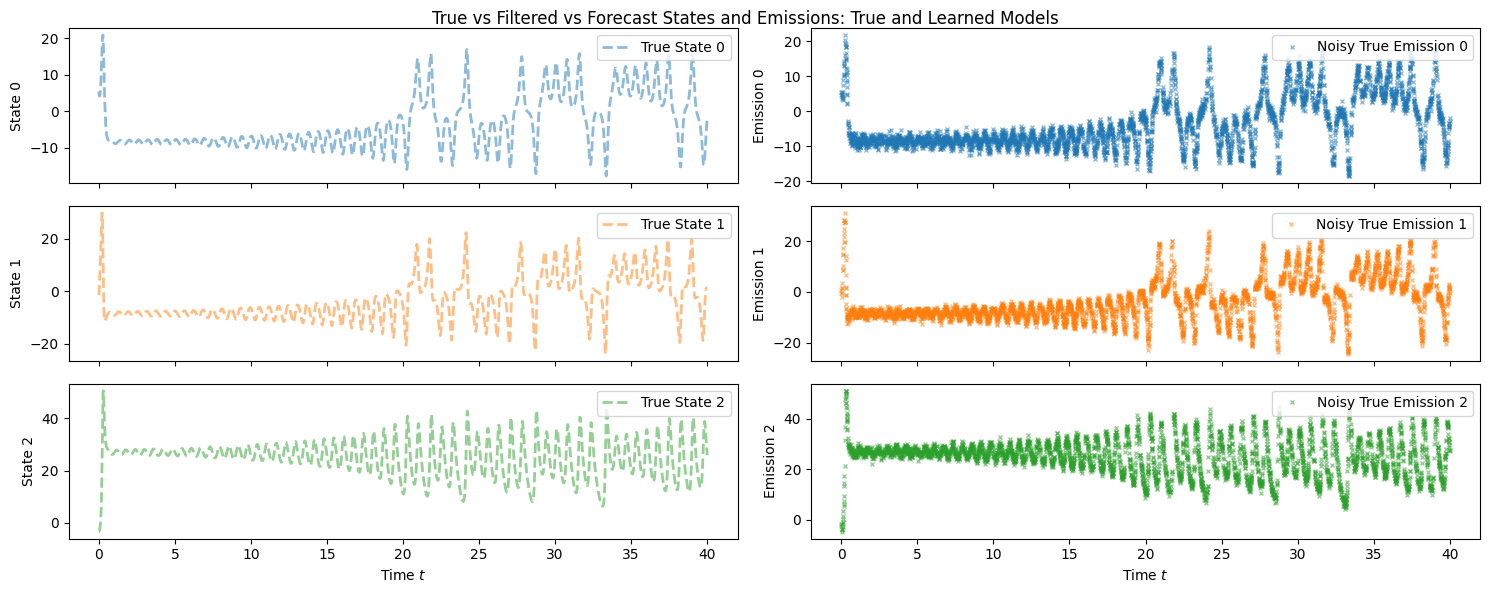

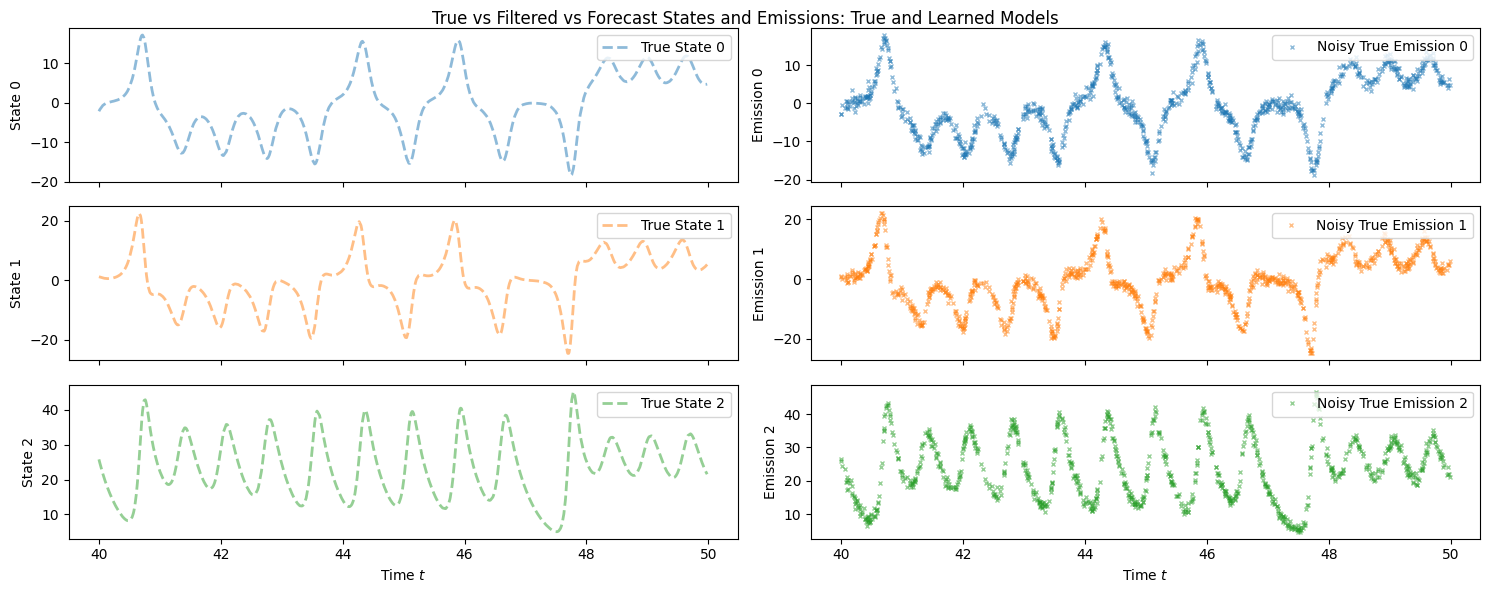

In [6]:
plot_advanced(time_grid_all=t_emissions, true_states=true_states, true_emissions_noisy=true_emissions, emission_function=true_params.emissions.emission_function)

plot_advanced(time_grid_all=t_emissions, true_states=true_states, true_emissions_noisy=true_emissions, emission_function=true_params.emissions.emission_function, t_start=0, t_end=40)

plot_advanced(time_grid_all=t_emissions, true_states=true_states, true_emissions_noisy=true_emissions, emission_function=true_params.emissions.emission_function, t_start=40, t_end=50)

# Parameter learning

### Define a new model that is learnable

- The learnable model will be a ContDiscreteNonlinearGaussianSSM

- We will define the same model family as the data-generating model
    - i.e., the model family class is the same

- However:
    - the dynamics drift function will not-initialized to true values, and will be learnable
    - The rest of the model components will NOT be learnable

### CODE hint

- By default, all ParamProperties are set to trainable=True

- So, make sure you EXPLICITLY set trainable=False for all parameters you DO NOT want to learn/infer

In [7]:
## Main settings
state_dim = 3
emission_dim = 3

# The only learnable parameters are those in the learnable_drift
drift_parameter_guess = jnp.array(
    [11.0, 21.0, 2 / 3]
    )
learnable_drift = {
    "params": lorenz63_drift(params=drift_parameter_guess),
    "props": lorenz63_drift(params=ParameterProperties()),
}

## All below parameters are NOT learnable
learnable_diffusion_cov = {
    "params": LearnableMatrix(
        params=jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            trainable=False,
            constrainer=RealToPSDBijector()
        )
    ),
}

# The diffusion coefficient is fixed to non-learnable identity
learnable_diffusion_coefficient = {
    "params": LearnableMatrix(
        params=true_diffusion_coefficient_param * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(trainable=False)
    ),
}

# The emission function is fixed to non-learnable identity
learnable_emission = {
    "params": LearnableLinear(
        weights=H,
        bias=jnp.zeros(emission_dim)
    ),
    "props": LearnableLinear(
        weights=ParameterProperties(trainable=False),
        bias=ParameterProperties(trainable=False)
    ),
}

# The emission covariance is fixed to non-learnable identity
learnable_emission_cov = {
    "params": LearnableMatrix(
        params=R
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            trainable=False,
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the initial mean and covariance
learnable_initial_mean = {
    "params": LearnableVector(
        params=jnp.zeros(state_dim)
    ),
    "props": LearnableVector(
        params=ParameterProperties(trainable=False)
    ),
}

learnable_initial_cov = {
    "params": LearnableMatrix(
        params=10.0 * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(params=ParameterProperties(trainable=False, constrainer=RealToPSDBijector())),
}

# Concatenate all parameters in dictionary, for later easy use
all_learnable_params = {
    "initial_mean": learnable_initial_mean,
    "initial_cov": learnable_initial_cov,
    "dynamics_drift": learnable_drift,
    "dynamics_diffusion_coefficient": learnable_diffusion_coefficient,
    "dynamics_diffusion_cov": learnable_diffusion_cov,
    "dynamics_approx_order": 2.,  # Check on this later
    "emission_function": learnable_emission,
    "emission_cov": learnable_emission_cov,
}


### Define, instantiate and initialize the learnable model

In [8]:
# Create CD-NLGSSM model
learnable_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
initial_learnable_params, learnable_props = learnable_model.initialize(
    next(keys),
    **all_learnable_params
)

# Frequentist parameter estimation: Maximum likelihood estimates MLE


## Maximum likelihood parameter estimation for an irregularly-sampled, continuous-discrete (non-linear) Gaussian dynamical system

- MLE based on SGD over marginalized log-probability
- We will use Extended Kalman Filtering to compute the marginal log probability

### Define the filter to use to compute the marginalized log-likelihood

In [9]:
# Filter: EKF
from continuous_discrete_nonlinear_gaussian_ssm import EKFHyperParams
filter_hyperparams = EKFHyperParams()

### Define the optimizer to use for SGD

In [10]:
# Build an optimizer
import optax
my_optimizer = optax.adam(1e-3) # maybe fancier if needed

# SGD optimizer related parameters
num_epochs = 2

### Fit the learnable model, using SGD to observed data, using the EKF filter to marginalize the latent states

In [11]:
# Fit test_model by running SGD, with EKF filter
fitted_params, neg_marginal_lls = learnable_model.fit_sgd(
    initial_learnable_params,
    learnable_props,
    true_emissions,
    t_emissions=t_emissions,
    filter_hyperparams=filter_hyperparams,
    optimizer=my_optimizer,
    num_epochs=num_epochs,
)

# Note that fit_sgd returns normalized negative log-likelihoods
# So we multiply it by the number of datapoints in emissions
marginal_lls = -neg_marginal_lls * true_emissions.size

### Plotting learning evolution

In [12]:
def plot_learning_curve(
        marginal_lls,
        true_model,
        true_params,
        # TODO: what are these for?
        test_model, test_params,
        true_emissions,
        t_emissions):
    plt.figure()
    plt.xlabel("iteration")
    nsteps = len(marginal_lls)
    true_logjoint = (
        true_model.log_prior(true_params) \
            + true_model.marginal_log_prob(
                true_params,
                true_emissions,
                t_emissions
        )
    )
    plt.axhline(true_logjoint, color = 'k', linestyle = ':', label="true")
    plt.plot(marginal_lls, label="estimated")
    plt.ylabel("marginal joint probability")

    # Adjust y-axis limits
    y_min = min(min(marginal_lls), true_logjoint) * 1.1  # 10% lower than the smallest value
    y_max = max(max(marginal_lls), true_logjoint) * 0.9  # 10% higher than the largest value
    plt.ylim([y_min, y_max])
    plt.yscale('symlog')
    plt.autoscale(enable=True, axis="x", tight=True)    
    plt.legend()

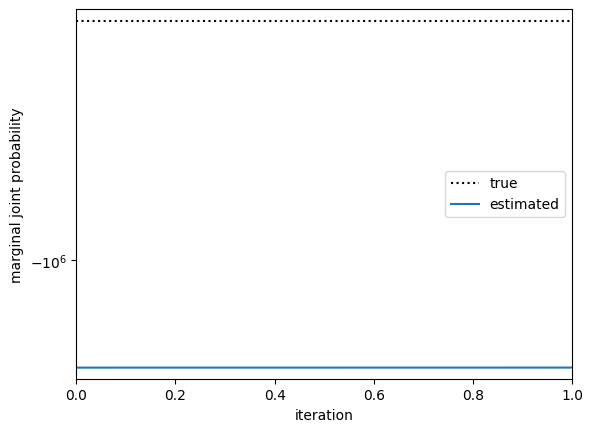

In [13]:
plot_learning_curve(
    marginal_lls,
    true_model,
    true_params,
    learnable_model,
    fitted_params,
    true_emissions,
    t_emissions,
)

### Plotting learned model

In [14]:
# Extract fitted params
fitted_C = fitted_params.emissions.emission_function.weights
fitted_d = fitted_params.emissions.emission_function.bias
fitted_R = fitted_params.emissions.emission_cov.params

# Compute filtered posterior
filtered_posterior = cdnlgssm_filter(
    fitted_params,
    emissions=true_emissions,
    t_emissions=t_emissions,
    hyperparams=filter_hyperparams,
)
# Compute predicted emissions, based on filtered sufficient statistics
filtered_emissions_mean = filtered_posterior.filtered_means @ fitted_C.T + fitted_d
filtered_emissions_cov = fitted_C @ filtered_posterior.filtered_covariances @ fitted_C.T + fitted_R
filtered_emissions_std = jnp.sqrt(jnp.array([filtered_emissions_cov[:, i, i] for i in range(emission_dim)])).T  # (T,E)

In [15]:
fitted_params.emissions.emission_function

LearnableLinear(weights=Array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32), bias=Array([0., 0., 0.], dtype=float32))

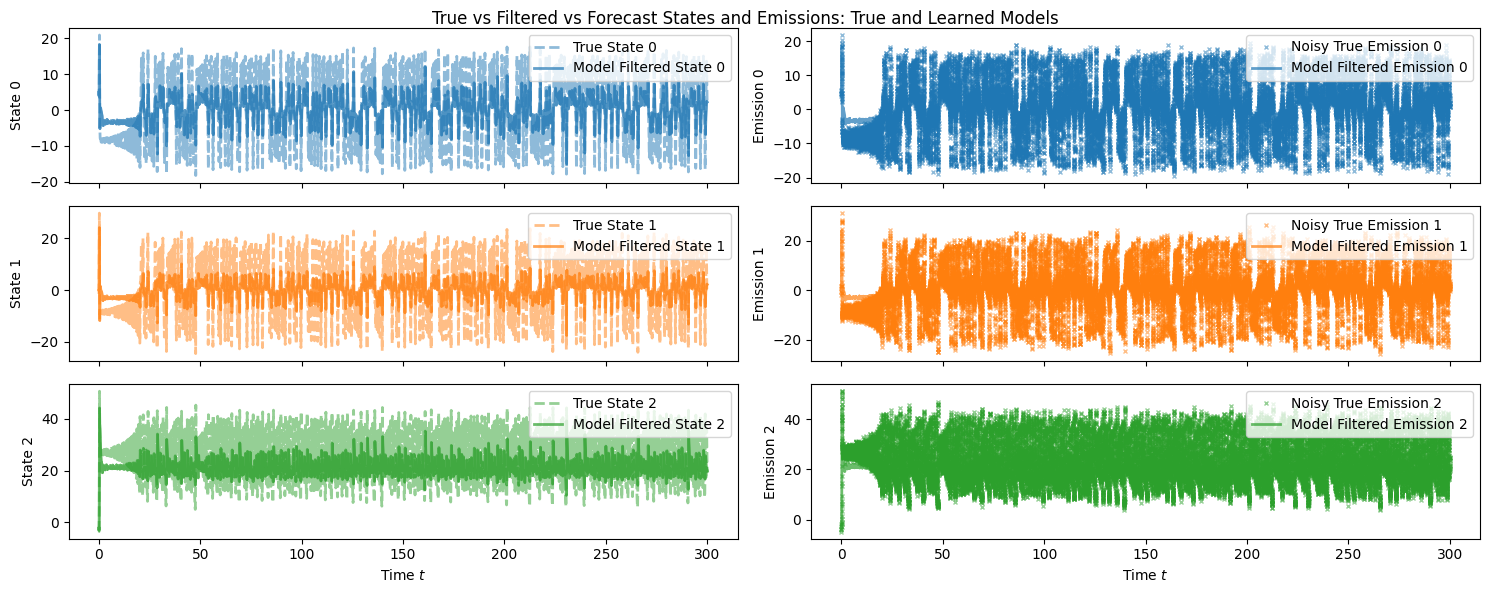

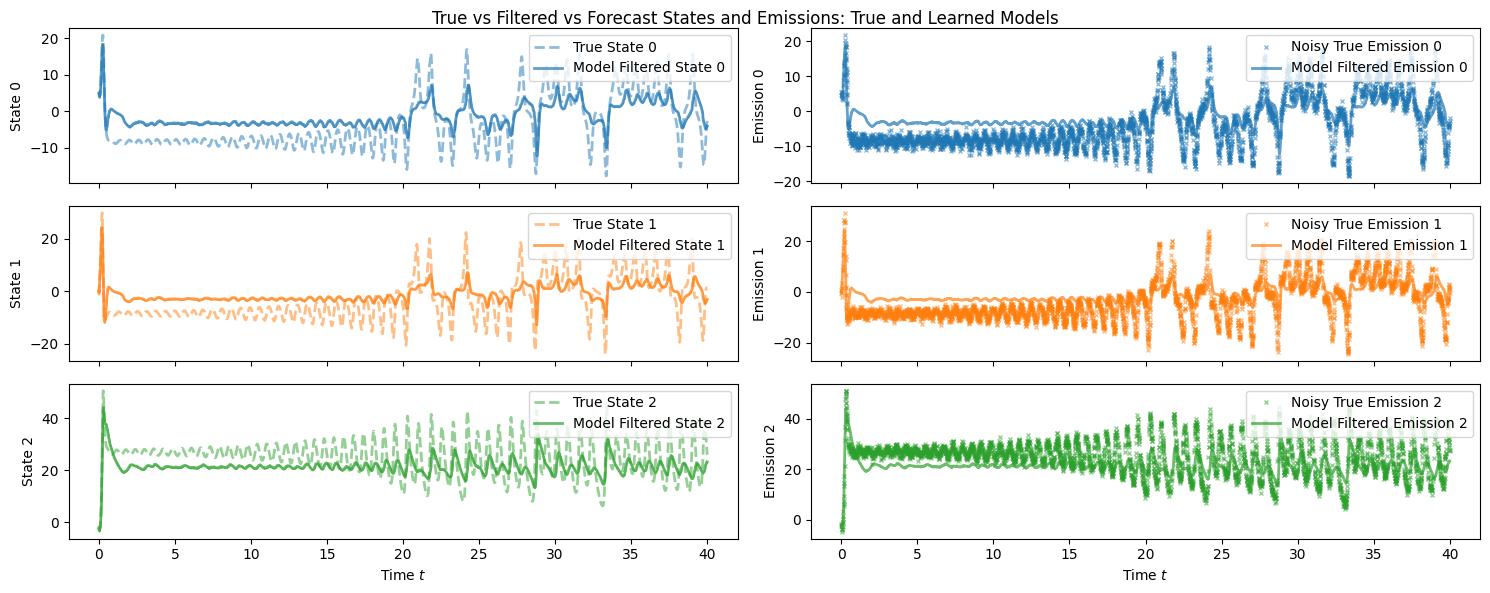

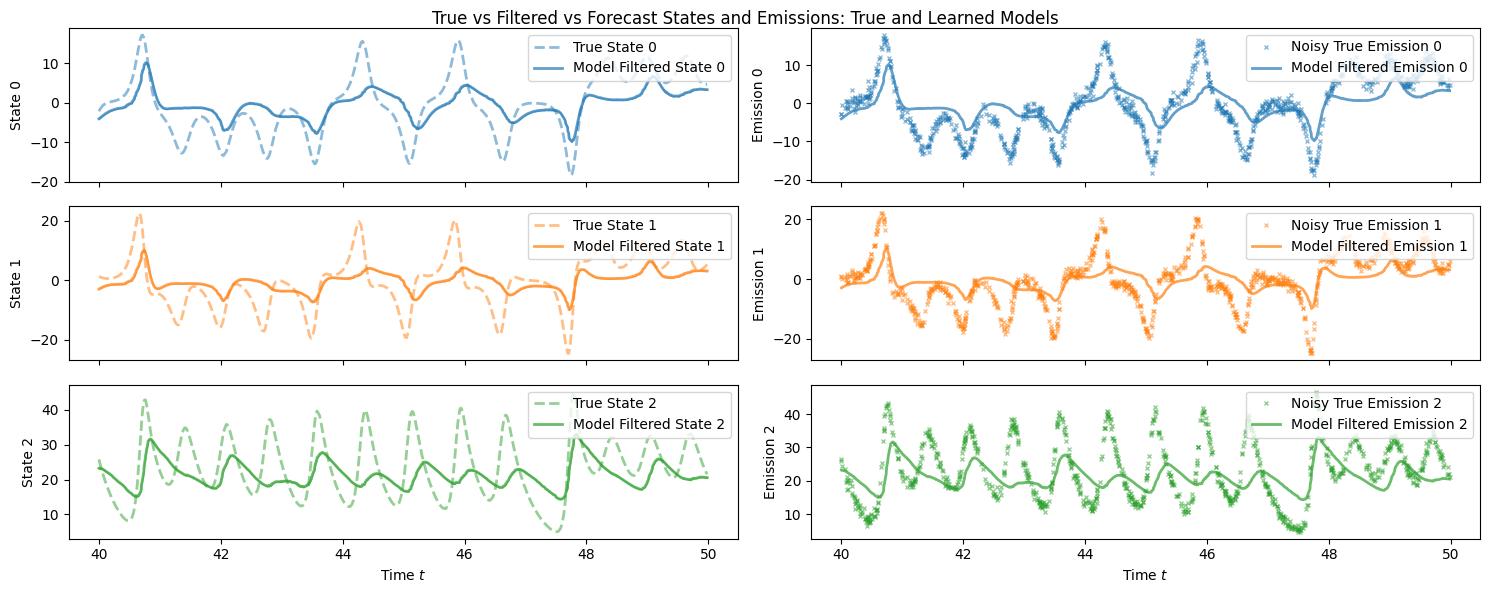

In [16]:
# Plot filtered posterior states and emissions
# We will visualize the whole time range using t_start=None and t_end=None.
# We will also zoom in on the first 40 time units using t_start=0 and t_end=40.
for t_start, t_end in [(None, None), (0, 40), (40, 50)]:
    plot_advanced(
        time_grid_all=t_emissions,
        true_states=true_states,
        true_emissions_noisy=true_emissions,
        emission_function=fitted_params.emissions.emission_function,
        time_grid_filter=t_emissions,
        model_filtered_states=filtered_posterior.filtered_means,
        model_filtered_covariances=filtered_posterior.filtered_covariances,
        t_start=t_start,
        t_end=t_end,
    )

### TODO: decide what to plot exactly

In [17]:
# Filtered states
plot_results(
    t_emissions,
    true_states,
    filtered_posterior.filtered_means,
    vmap(jnp.diag, in_axes=0)(filtered_posterior.filtered_covariances)
)

NameError: name 'plot_results' is not defined

In [ ]:
# Filtered emissions
print([
        true_emissions.shape,
        filtered_emissions_mean.shape,
        filtered_emissions_std.shape
    ]
)
plot_results(
    t_emissions,
    true_emissions,
    filtered_emissions_mean,
    filtered_emissions_std
)

# Bayesian parameter estimation: Maximum A-Posteriori (MAP) estimates

## Bayesian parameter estimation for an irregularly-sampled, continuous-discrete (non-linear) Gaussian dynamical system

### HMC w/ autodifferentiable filtering

We show how to use the [blackjax](https://github.com/blackjax-devs/blackjax) libray to compute the parameter posterior $p(\theta|y(1:T))$
for a nonlinear dynamical model.

We use the Extended Kalman filter to compute the marginal likelihood, $p(y(1:T) | \theta) = \int_{z(1:T)} p(z(1:T), y(1:T)|\theta)$.


### Auxiliary code and functions of use

In [26]:
@jit
def filter_emission(params):
    C = params.emissions.emission_function.weights
    d = params.emissions.emission_function.bias
    filtered_posterior = cdnlgssm_filter(
        params,
        emissions=emissions,
        t_emissions=t_emissions,
        hyperparams=filter_hyperparams
    )

    return filtered_posterior.filtered_means @ C.T + d

In [27]:
def plot_param_distributions(samples, true, sgd, name='', burn_in_frac=0.5):
    """
    Plots N_params horizontal box plots for the given N_params x N_samples matrix.

    Parameters:
    - samples: N_params x N_samples matrix of parameter samples.
    - true: N_params array of true parameter values.
    - sgd: N_params array of SGD estimates.
    - name: Name of the parameter set.
    - burn_in_frac: Fraction of samples to discard as burn-in.

    Returns:
    - A matplotlib figure with N_params horizontal box plots.
    """
    N_params = samples.shape[0]
    fig, ax = plt.subplots(figsize=(10, N_params * 2))  # Adjust figure size based on number of parameters

    # apply burn-in
    burn_in = int(burn_in_frac * samples.shape[1])
    samples = samples[:, burn_in:]
    
    # Create box plots
    ax.boxplot(samples, vert=False, patch_artist=True)

    # Set the y-axis labels to show parameter indices
    ax.set_yticks(range(1, N_params + 1))
    ax.set_yticklabels(["Parameter {}".format(i + 1) for i in range(N_params)])

    # Plot ground truth and estimates
    ax.scatter(sgd, range(1, N_params + 1), color="magenta", marker="o", s=100, label="Initial Estimate", zorder=3)
    ax.scatter(true, range(1, N_params + 1), color="red", marker="x", s=100, label="Ground Truth", zorder=4)

    plt.xlabel("Value")
    plt.ylabel("Parameters")
    plt.title("{} Parameter Distributions".format(name))
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_all(param_samples, burn_in_frac=0.5):
    """
    Plots the posterior distributions of all parameters.
    Burn-in is removed from the samples.
    """
    plot_param_distributions(
        param_samples.initial.mean.T, true_params.initial.mean, fitted_params.initial.mean, name="Initial mean",
        burn_in_frac=burn_in_frac
    )
    plot_param_distributions(
        param_samples.initial.cov.reshape(param_samples.initial.cov.shape[0], -1).T,
        true_params.initial.cov.flatten(),
        fitted_params.initial.cov.flatten(),
        name="Initial cov",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.drift.weights.reshape(param_samples.dynamics.drift.weights.shape[0], -1).T,
        true_params.dynamics.drift.weights,
        fitted_params.dynamics.drift.weights,
        name="Dynamics drift weights",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.drift.bias.reshape(param_samples.dynamics.drift.bias.shape[0], -1).T,
        true_params.dynamics.drift.bias,
        fitted_params.dynamics.drift.bias,
        name="Dynamics drift bias",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.diffusion_cov.params.reshape(param_samples.dynamics.diffusion_cov.params.shape[0], -1).T,
        true_params.dynamics.diffusion_cov.params.flatten(),
        fitted_params.dynamics.diffusion_cov.params.flatten(),
        name="Dynamics diffusion cov",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.diffusion_coefficient.params.reshape(
            param_samples.dynamics.diffusion_coefficient.params.shape[0], -1
        ).T,
        true_params.dynamics.diffusion_coefficient.params.flatten(),
        fitted_params.dynamics.diffusion_coefficient.params.flatten(),
        name="Dynamics diffusion coefficient",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_function.weights.reshape(
            param_samples.emissions.emission_function.weights.shape[0], -1
        ).T,
        true_params.emissions.emission_function.weights.flatten(),
        fitted_params.emissions.emission_function.weights.flatten(),
        name="Emissions function weights",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_function.bias.reshape(
            param_samples.emissions.emission_function.bias.shape[0], -1
        ).T,
        true_params.emissions.emission_function.bias.flatten(),
        fitted_params.emissions.emission_function.bias.flatten(),
        name="Emissions function bias",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_cov.params.reshape(param_samples.emissions.emission_cov.params.shape[0], -1).T,
        true_params.emissions.emission_cov.params.flatten(),
        fitted_params.emissions.emission_cov.params.flatten(),
        name="Emissions cov",
        burn_in_frac=burn_in_frac,
    )

### Model MAP learning, based on HMC
- We will use Extended Kalman Filtering to compute the marginal log probability, for SGD to optimize

In [28]:
# Filter: EKF
hmc_filter_hyperparams = EKFHyperParams()

# Blackjax for HMC
import blackjax
# HMC hyperparameters
hmc_samples = 5
hmc_warmup = 1
hmc_integration_steps=3

### Randomly initialized HMC

In [ ]:
# Run HMC: initialized at randomly initialized parameters
param_samples, lps = learnable_model.fit_hmc(
    initial_learnable_params,
    learnable_props,
    true_emissions,
    t_emissions=t_emissions,
    filter_hyperparams=hmc_filter_hyperparams,
    num_samples=hmc_samples,
    warmup_steps=hmc_warmup,
    num_integration_steps=hmc_integration_steps,
)

In [ ]:
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log probability")

In [ ]:
# compute eigenvalues of param_samples.dynamics.drift.params across samples using vmap
eigvals = vmap(jnp.linalg.eigvals)(param_samples.dynamics.drift.params)

# plot the complex part of the eigenvalues
plt.plot(eigvals.real[:, 0], '-', label="first Real")
plt.plot(eigvals.imag[:, 0], label="first Imag")
plt.plot(eigvals.real[:, 1], ':', label="second Real")
plt.plot(eigvals.imag[:, 1], label="second Imag")
plt.plot(param_samples.dynamics.drift.params[:, 1, 0], label="First off-diagonal")
plt.plot(param_samples.dynamics.drift.params[:, 0, 1], label="Second off-diagonal")
plt.yscale("symlog")
plt.legend()
plt.title("Eigenvalues of the drift matrix")
plt.xlabel("Iteration")

In [ ]:
filtered_emissions = vmap(filter_emission)(param_samples)
filtered_emissions_mean = filtered_emissions.mean(axis=0)
filtered_emissions_std = jnp.std(filtered_emissions, axis=0)

# note that this shows a distribution of filtered means
# Unlike earlier plots, it does not show the filtered covariances, 
# which would add an appearance of greater uncertainty.
print(
    [true_emissions.shape,
     filtered_emissions.shape,
     filtered_emissions_mean.shape,
     filtered_emissions_std.shape
    ]
)
plot_results(t_emissions, true_emissions, filtered_emissions_mean, filtered_emissions_std)

In [ ]:
plot_all(param_samples)

### SGD initialized HMC

In [ ]:
# Now, run HMC initialized at the SGD-fitted parameters
param_samples, lps = learnable_model.fit_hmc(
    fitted_params,
    learnable_props,
    true_emissions,
    t_emissions=t_emissions,
    filter_hyperparams=hmc_filter_hyperparams,
    num_samples=hmc_samples,
    warmup_steps=hmc_warmup,
    num_integration_steps=hmc_integration_steps,
)

In [ ]:
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log probability")

In [ ]:
# compute eigenvalues of param_samples.dynamics.drift.params across samples using vmap
eigvals = vmap(jnp.linalg.eigvals)(param_samples.dynamics.drift.weights)

# plot the complex part of the eigenvalues
plt.plot(eigvals.real[:, 0], '-', label="first Real")
plt.plot(eigvals.imag[:, 0], label="first Imag")
plt.plot(eigvals.real[:, 1], ':', label="second Real")
plt.plot(eigvals.imag[:, 1], label="second Imag")
plt.plot(param_samples.dynamics.drift.weights[:, 1, 0], label="First off-diagonal")
plt.plot(param_samples.dynamics.drift.weights[:, 0, 1], label="Second off-diagonal")
plt.yscale("symlog")
plt.legend()
plt.title("Eigenvalues of the drift matrix")
plt.xlabel("Iteration")

In [ ]:
filtered_emissions = vmap(filter_emission)(param_samples)
filtered_emissions_mean = filtered_emissions.mean(axis=0)
filtered_emissions_std = jnp.std(filtered_emissions, axis=0)

# note that this shows a distribution of filtered means
# Unlike earlier plots, it does not show the filtered covariances, 
# which would add an appearance of greater uncertainty.
print(
    [
        true_emissions.shape,
        filtered_emissions.shape,
        filtered_emissions_mean.shape,
        filtered_emissions_std.shape
    ]
)
plot_results(t_emissions,
             true_emissions,
             filtered_emissions_mean,
             filtered_emissions_std
)

In [ ]:
plot_all(param_samples)